<a href="https://colab.research.google.com/github/johncoogan53/XAI_HW6/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

AIPI 590 - XAI | Assignment 06
Description:

This assignment will utilize

John Coogan

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost
from sklearn.model_selection import train_test_split

from sklearn.inspection import PartialDependenceDisplay
from alepython import ale_plot

## Data ingestion and correlation assessment

In [3]:
data = pd.read_csv('https://github.com/johncoogan53/XAI_HW6/raw/refs/heads/main/user_behavior_dataset.csv')

Our data comes from Kaggle Datasets for mobile device usage: https://www.kaggle.com/datasets/valakhorasani/mobile-device-usage-and-user-behavior-dataset?resource=download

In [4]:
data.head()

,User ID,Device Model,Operating System,App Usage Time (min/day),Screen On Time (hours/day),Battery Drain (mAh/day),Number of Apps Installed,Data Usage (MB/day),Age,Gender,User Behavior Class
0,1,Google Pixel 5,Android,393,6.4,1872,67,1122,40,Male,4
1,2,OnePlus 9,Android,268,4.7,1331,42,944,47,Female,3
2,3,Xiaomi Mi 11,Android,154,4.0,761,32,322,42,Male,2
3,4,Google Pixel 5,Android,239,4.8,1676,56,871,20,Male,3
4,5,iPhone 12,iOS,187,4.3,1367,58,988,31,Female,3


In [5]:
data.columns

Index(['User ID', 'Device Model', 'Operating System',
       'App Usage Time (min/day)', 'Screen On Time (hours/day)',
       'Battery Drain (mAh/day)', 'Number of Apps Installed',
       'Data Usage (MB/day)', 'Age', 'Gender', 'User Behavior Class'],
      dtype='object')

In [6]:
#we are only going to include the variables that we believe may have a legitimate impact on screen time
data_trunc = data[['Age','Gender','User Behavior Class','Number of Apps Installed','Screen On Time (hours/day)']]

In [7]:
data_trunc.head()

,Age,Gender,User Behavior Class,Number of Apps Installed,Screen On Time (hours/day)
0,40,Male,4,67,6.4
1,47,Female,3,42,4.7
2,42,Male,2,32,4.0
3,20,Male,3,56,4.8
4,31,Female,3,58,4.3


In [12]:
data_trunc.dtypes


Age                             int64
Gender                         object
User Behavior Class             int64
Number of Apps Installed        int64
Screen On Time (hours/day)    float64
dtype: object

In [13]:
#convert gender into a binary variable
data_trunc['Gender'] = data_trunc['Gender'].map({'Male': 0, 'Female': 1})

/tmp/ipykernel_13921/3458206947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_trunc['Gender'] = data_trunc['Gender'].map({'Male': 0, 'Female': 1})


Screen On Time (hours/day)    1.000000
User Behavior Class           0.964581
Number of Apps Installed      0.946975
Age                           0.017232
Gender                       -0.003573
Name: Screen On Time (hours/day), dtype: float64


<Axes: >

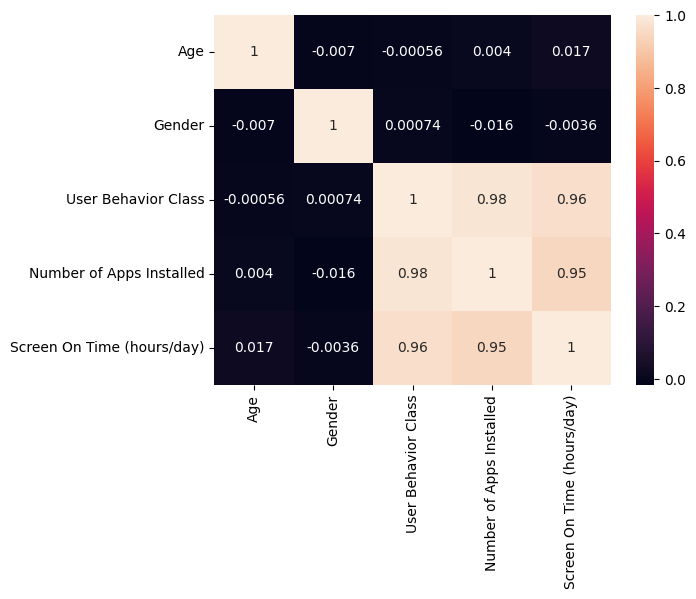

In [18]:
#Correlation plot between variables and target Screen On Time (hours/day)
print(data_trunc.corr()['Screen On Time (hours/day)'].sort_values(ascending=False))
#plot the correlation matrix
corr_matrix = data_trunc.corr()
sns.heatmap(corr_matrix, annot=True)

We can see that from the bottom row of the correlation plot that User Behavior Class and Number of Apps Installed are highly correlated with screen time while Age and Gender are less strongly correlated. Gender seems to have a negative correlation which is not surprising since the magnitude is small. The lack of strong correlation between age and screen time is quite surprising, hopefully we can see more in our plots

## XGBoost Regression

In [21]:
y = data_trunc['Screen On Time (hours/day)']
X = data_trunc.drop(columns=['Screen On Time (hours/day)'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
model = xgboost.XGBRegressor().fit(X_train, y_train)

## Partial Dependency Plot

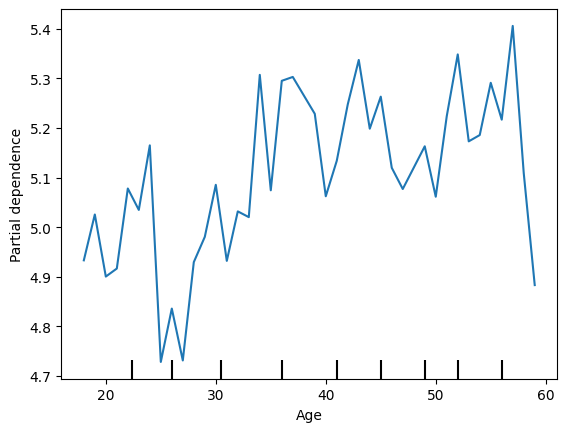

In [23]:
#feature of interest
features = ["Age"]
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='average')

This is really interesting. We see essentially increasing screen time with age but there is a dip in the late 20's early 30's. This appears to correspond with many individuals early career which may limit the amount of time one cans spend on their phone. It is interesting to see that, contrary to my intuition, teens are not the hightest screentime users and, while noisy, older adults have generally the highest screen time. 

## ALE Plots

Lets look at an ALE plot for Age

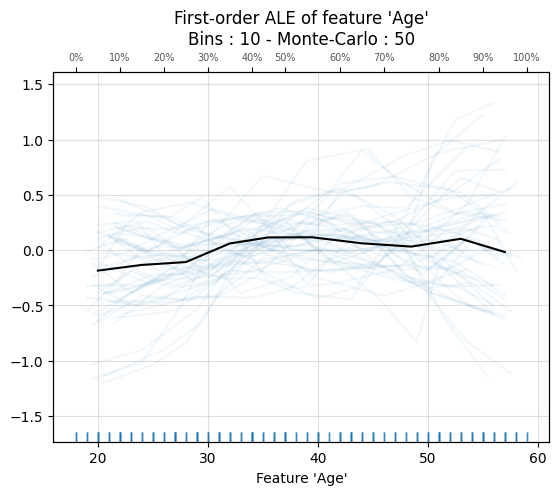

<Axes: title={'center': "First-order ALE of feature 'Age'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'Age'">

In [24]:
ale_plot(model, X_train, 'Age', monte_carlo=True)

We can see here by the largely horizontal line that the impact on our prediction caused by age appears to be minimal. This aligns to our assessment of correlation but there is more to see here. Lets look at number of apps to see what a highly correlated variable might look like here:

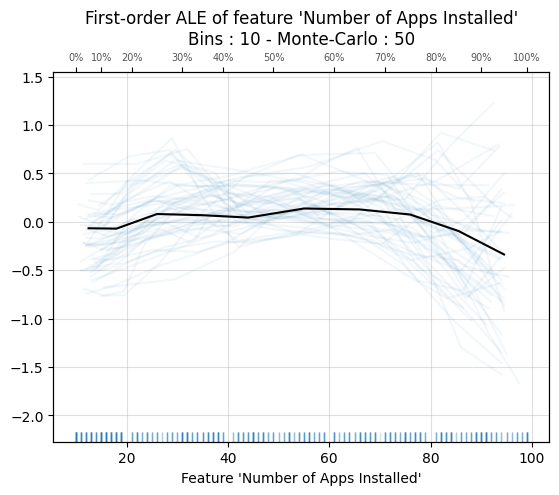

<Axes: title={'center': "First-order ALE of feature 'Number of Apps Installed'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'Number of Apps Installed'">

In [25]:
ale_plot(model, X_train, 'Number of Apps Installed', monte_carlo=True)

This is interesting since we would expect to see steeper lines that deviated from 0 for a highly correlated variable. Ultimately this line represents the impact on the predictions of our model and the largely horizontal line indicates minimal impact for both variables.

## ICE Plots

Here we will look at age again with an ICE plot which should show us a more detailed view of what the individual observations behavior are with respect to screen time.

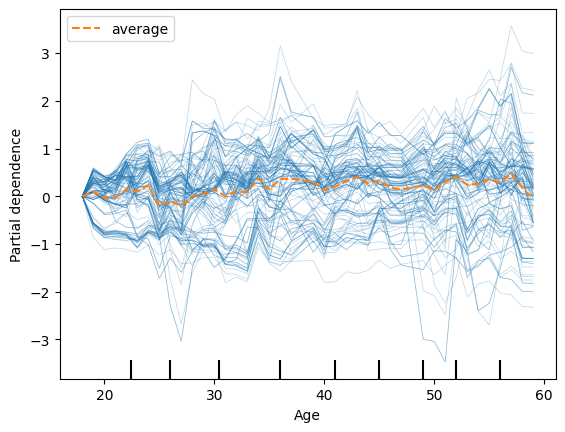

In [26]:
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='both', centered=True)

Now we can see how complex and unique the age variable really is. The singular horizontal line from the previous plots can mislead an analyst into reducing the complex interaction of the variable with the target. We can see that there are significant outliers below the norm in the late 20's as well as in the 50's while the high end of age sees outliers above the norm. 

This is a much more insightful way to analyze the impact our variables have on our modeling outputs. It starts to raise more questions that would otherwise go unanswered:

* why does there appear to be a bimodal (branch) distribution in the late teens?
* Even screen time across all ages runs counter to our intuition, is screen-on time actually valid? Does the fact that younger tech-natives use phones faster and so may keep their phone on for less time confound our results here?

These are all intersting questions and the use of these plots allows us to not ony model phenomena but also visibly demonstrate trends picked up by the model for transparency.